# 02B — Global Spillover Analysis

**Purpose**: How global variables transmit into India markets

**Key Questions**:
- USD strength → which sectors suffer?
- Oil ↑ → CPI → which indices?
- US yields ↑ → EM equity response?

**Outputs**: Spillover matrix, Lag distribution charts

---

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

PROCESSED_PATH = Path('../data_processed')

# Load data
combined = pd.read_parquet(PROCESSED_PATH / 'macro_sector_monthly_matrix.parquet')

# Load global weekly data for higher frequency analysis
try:
    global_equity = pd.read_parquet(PROCESSED_PATH / 'global_equity_weekly.parquet')
    global_fx = pd.read_parquet(PROCESSED_PATH / 'global_fx_weekly.parquet')
    global_commodities = pd.read_parquet(PROCESSED_PATH / 'global_commodities_weekly.parquet')
    india_daily = pd.read_parquet(PROCESSED_PATH / 'india_indices_daily.parquet')
    print("✓ Loaded all weekly/daily data")
except Exception as e:
    print(f"Note: Some global data not available: {e}")

print(f"Combined matrix: {combined.shape}")

✓ Loaded all weekly/daily data
Combined matrix: (132, 93)


## 1. Define Global → India Transmission Channels

| Channel | Global Variable | India Impact | Mechanism |
|---------|----------------|--------------|------------|
| **Risk Sentiment** | S&P 500, MSCI EM | All sectors | Flight to safety, FII flows |
| **USD Strength** | DXY, USD/INR | IT (+), Auto (-), Metals (-) | Export competitiveness, import costs |
| **Oil Shock** | Brent | OMC (-), Auto (-), CPI (+) | Input costs, fiscal |
| **US Rates** | US 10Y | Banks, NBFCs, IT | Carry trade, EM flows |
| **China Growth** | CSI 300, Copper | Metals, Chemicals | Global demand |

In [2]:
# Define transmission channels for analysis
TRANSMISSION_CHANNELS = {
    'USD_STRENGTH': {
        'global_var': 'DXY',
        'india_sectors': ['NIFTY_IT', 'NIFTY_AUTO', 'NIFTY_BANK'],
        'expected_sign': {'NIFTY_IT': '+', 'NIFTY_AUTO': '-', 'NIFTY_BANK': '-'},
        'mechanism': 'USD strength benefits IT exports, hurts importers'
    },
    'RISK_SENTIMENT': {
        'global_var': 'SP500',
        'india_sectors': ['NIFTY_50', 'NIFTY_BANK', 'NIFTY_FIN_SERVICE'],
        'expected_sign': {'NIFTY_50': '+', 'NIFTY_BANK': '+', 'NIFTY_FIN_SERVICE': '+'},
        'mechanism': 'Risk-on flows into EM equities'
    },
    'OIL_SHOCK': {
        'global_var': 'BRENT',
        'india_sectors': ['NIFTY_AUTO', 'NIFTY_ENERGY', 'NIFTY_INFRA'],
        'expected_sign': {'NIFTY_AUTO': '-', 'NIFTY_ENERGY': '+/-', 'NIFTY_INFRA': '-'},
        'mechanism': 'Oil price affects fuel costs and OMC margins'
    },
    'US_RATES': {
        'global_var': 'US10Y',
        'india_sectors': ['NIFTY_BANK', 'NIFTY_IT', 'NIFTY_FIN_SERVICE'],
        'expected_sign': {'NIFTY_BANK': '-', 'NIFTY_IT': '-', 'NIFTY_FIN_SERVICE': '-'},
        'mechanism': 'Higher US rates → EM outflows'
    }
}

print(f"Defined {len(TRANSMISSION_CHANNELS)} transmission channels")

Defined 4 transmission channels


## 2. Calculate Global → India Correlations

In [3]:
# Get index and global columns
index_cols = [c for c in combined.columns if c.startswith('IDX_')]
global_cols = [c for c in combined.columns if c.startswith('GLOBAL_')]

# Calculate monthly returns for global variables
if len(global_cols) > 0:
    # Calculate correlation matrix
    global_india_corr = pd.DataFrame(
        index=global_cols,
        columns=index_cols
    )
    
    for g_col in global_cols:
        for i_col in index_cols:
            valid = combined[[g_col, i_col]].dropna()
            if len(valid) >= 30:
                global_india_corr.loc[g_col, i_col] = valid[g_col].corr(valid[i_col])
    
    print(f"Global → India correlation matrix: {global_india_corr.shape}")
else:
    print("No global columns found. Run 00C notebook first.")

Global → India correlation matrix: (8, 21)


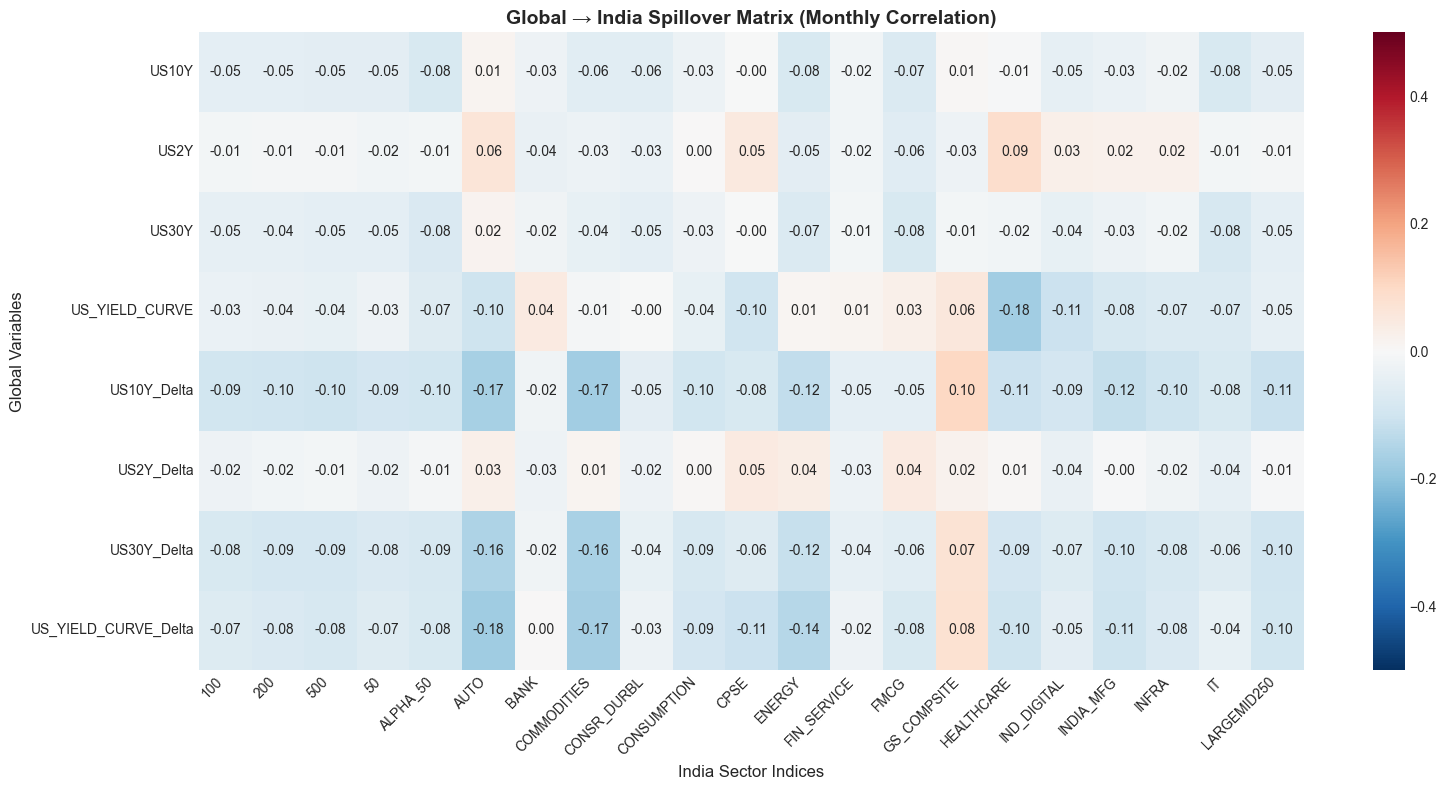

✓ Saved: global_spillover_heatmap.png


In [4]:
# Plot spillover heatmap
if 'global_india_corr' in dir() and global_india_corr.shape[0] > 0:
    # Clean names
    clean_global = [c.replace('GLOBAL_', '') for c in global_india_corr.index]
    clean_india = [c.replace('IDX_', '').replace('NIFTY_', '') for c in global_india_corr.columns]
    
    plot_df = global_india_corr.copy()
    plot_df.index = clean_global
    plot_df.columns = clean_india
    plot_df = plot_df.astype(float)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(
        plot_df,
        cmap='RdBu_r',
        center=0,
        vmin=-0.5,
        vmax=0.5,
        annot=True,
        fmt='.2f',
        ax=ax
    )
    ax.set_title('Global → India Spillover Matrix (Monthly Correlation)', fontsize=14, fontweight='bold')
    ax.set_xlabel('India Sector Indices', fontsize=12)
    ax.set_ylabel('Global Variables', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'global_spillover_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved: global_spillover_heatmap.png")

## 3. Lag Analysis (Lead-Lag Relationships)

In [5]:
def lag_correlation(series1: pd.Series, series2: pd.Series, max_lag: int = 6) -> pd.DataFrame:
    """
    Calculate correlation at different lags.
    Positive lag = series1 leads series2
    """
    results = []
    
    for lag in range(-max_lag, max_lag + 1):
        if lag >= 0:
            s1_shifted = series1.shift(lag)
            s2_aligned = series2
        else:
            s1_shifted = series1
            s2_aligned = series2.shift(-lag)
        
        valid = pd.concat([s1_shifted, s2_aligned], axis=1).dropna()
        if len(valid) >= 20:
            corr = valid.iloc[:, 0].corr(valid.iloc[:, 1])
            results.append({'lag': lag, 'correlation': corr})
    
    return pd.DataFrame(results)

print("Lag correlation function defined")

Lag correlation function defined


In [6]:
# Analyze key transmission pairs
KEY_PAIRS = [
    ('GLOBAL_US10Y', 'IDX_NIFTY_BANK', 'US 10Y → NIFTY Bank'),
    ('GLOBAL_US10Y_Delta', 'IDX_NIFTY_BANK', 'US 10Y Δ → NIFTY Bank'),
]

# Find available pairs
available_pairs = []
for g, i, desc in KEY_PAIRS:
    if g in combined.columns and i in combined.columns:
        available_pairs.append((g, i, desc))

# If no predefined pairs available, find top correlations
if len(available_pairs) == 0 and 'global_india_corr' in dir():
    print("Finding top correlated pairs...")
    top_pairs = []
    for g_col in global_india_corr.index:
        for i_col in global_india_corr.columns:
            val = global_india_corr.loc[g_col, i_col]
            if pd.notna(val):
                top_pairs.append((g_col, i_col, abs(val)))
    
    top_pairs = sorted(top_pairs, key=lambda x: x[2], reverse=True)[:4]
    available_pairs = [(g, i, f"{g.replace('GLOBAL_','')} → {i.replace('IDX_','')}")
                       for g, i, _ in top_pairs]

print(f"Analyzing {len(available_pairs)} pairs for lag structure")

Analyzing 2 pairs for lag structure


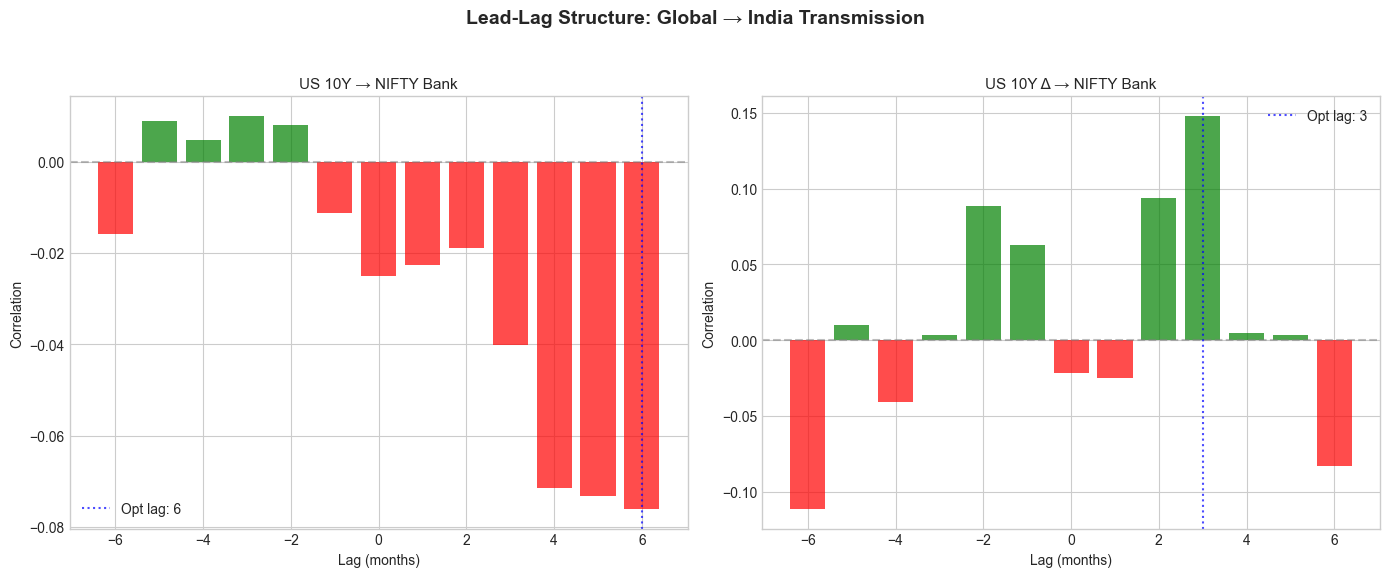

✓ Saved: lag_distribution_charts.png


In [7]:
# Plot lag distributions
if len(available_pairs) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (g_col, i_col, desc) in enumerate(available_pairs[:4]):
        lag_df = lag_correlation(combined[g_col], combined[i_col], max_lag=6)
        
        if len(lag_df) > 0:
            ax = axes[idx]
            colors = ['green' if c > 0 else 'red' for c in lag_df['correlation']]
            ax.bar(lag_df['lag'], lag_df['correlation'], color=colors, alpha=0.7)
            ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            ax.set_xlabel('Lag (months)')
            ax.set_ylabel('Correlation')
            ax.set_title(desc, fontsize=11)
            
            # Mark optimal lag
            opt_idx = lag_df['correlation'].abs().idxmax()
            opt_lag = lag_df.loc[opt_idx, 'lag']
            ax.axvline(x=opt_lag, color='blue', linestyle=':', alpha=0.7, label=f'Opt lag: {opt_lag}')
            ax.legend()
    
    # Hide unused subplots
    for idx in range(len(available_pairs), 4):
        axes[idx].set_visible(False)
    
    plt.suptitle('Lead-Lag Structure: Global → India Transmission', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'lag_distribution_charts.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved: lag_distribution_charts.png")
else:
    print("No pairs available for lag analysis")

## 4. Shock Transmission Analysis

In [8]:
def identify_shocks(series: pd.Series, threshold: float = 2.0) -> pd.DataFrame:
    """
    Identify shock events (moves > threshold std deviations).
    """
    returns = series.pct_change() * 100
    std = returns.std()
    mean = returns.mean()
    
    z_scores = (returns - mean) / std
    
    shocks = pd.DataFrame({
        'date': returns.index,
        'return': returns.values,
        'z_score': z_scores.values,
        'is_shock': abs(z_scores) > threshold,
        'direction': np.where(z_scores > threshold, 'positive', 
                             np.where(z_scores < -threshold, 'negative', 'none'))
    })
    
    return shocks[shocks['is_shock']]

print("Shock identification function defined")

Shock identification function defined


In [9]:
# Analyze response to global shocks
def shock_response_analysis(global_series: pd.Series, india_series: pd.Series, 
                            window: int = 3) -> dict:
    """
    Analyze India response in window following global shocks.
    """
    shocks = identify_shocks(global_series)
    
    if len(shocks) < 5:
        return {'n_shocks': 0}
    
    india_returns = india_series.pct_change() * 100
    
    responses = []
    for idx, shock in shocks.iterrows():
        shock_date = shock['date']
        # Get India response in following months
        future_dates = india_returns.index[india_returns.index > shock_date][:window]
        if len(future_dates) > 0:
            cum_response = india_returns.loc[future_dates].sum()
            responses.append({
                'date': shock_date,
                'global_shock': shock['return'],
                'direction': shock['direction'],
                'india_response': cum_response
            })
    
    response_df = pd.DataFrame(responses)
    
    return {
        'n_shocks': len(response_df),
        'avg_response_positive': response_df[response_df['direction']=='positive']['india_response'].mean(),
        'avg_response_negative': response_df[response_df['direction']=='negative']['india_response'].mean(),
        'response_data': response_df
    }

# Run shock analysis for available pairs
shock_results = {}
for g, i, desc in available_pairs[:4]:
    result = shock_response_analysis(combined[g], combined[i])
    if result['n_shocks'] > 0:
        shock_results[desc] = result
        print(f"{desc}:")
        print(f"  Shocks analyzed: {result['n_shocks']}")
        print(f"  Avg response to positive shock: {result['avg_response_positive']:.2f}%")
        print(f"  Avg response to negative shock: {result['avg_response_negative']:.2f}%")
        print()

US 10Y → NIFTY Bank:
  Shocks analyzed: 10
  Avg response to positive shock: -2647.88%
  Avg response to negative shock: -3646.34%

US 10Y Δ → NIFTY Bank:
  Shocks analyzed: 6
  Avg response to positive shock: -1315.14%
  Avg response to negative shock: -281.36%



## 5. Daily Spillover (Higher Frequency)

Weekly correlation (Global → India): -0.069


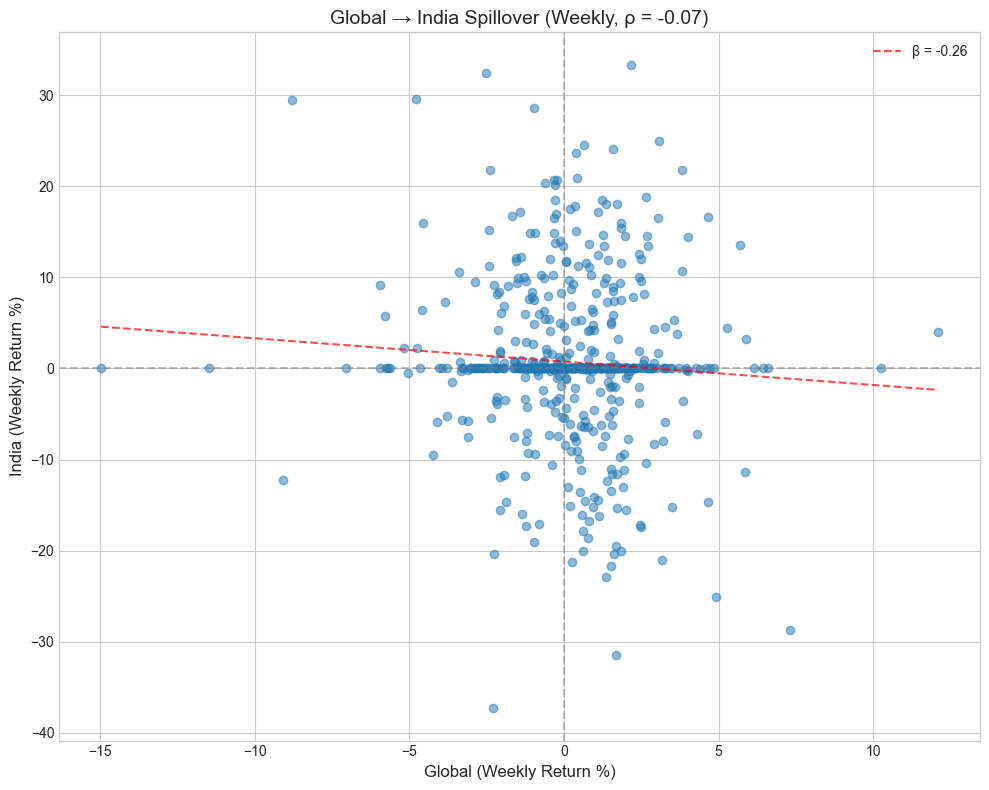

✓ Saved: daily_spillover_scatter.png


In [10]:
# If daily data available, analyze intraday/next-day spillovers
if 'global_equity' in dir() and 'india_daily' in dir():
    # Calculate daily returns
    global_daily_ret = global_equity.pct_change() * 100
    india_daily_ret = india_daily.pct_change() * 100
    
    # Resample to weekly for cleaner analysis
    global_weekly_ret = global_daily_ret.resample('W-FRI').sum()
    india_weekly_ret = india_daily_ret.resample('W-FRI').sum()
    
    # Align dates
    common_idx = global_weekly_ret.index.intersection(india_weekly_ret.index)
    
    # Select key global and India indices
    if 'SP500' in global_weekly_ret.columns:
        global_key = global_weekly_ret.loc[common_idx, 'SP500']
    elif len(global_weekly_ret.columns) > 0:
        global_key = global_weekly_ret.loc[common_idx].iloc[:, 0]
    else:
        global_key = None
    
    india_key_cols = [c for c in india_weekly_ret.columns if 'NIFTY_50' in c or 'NIFTY50' in c]
    if not india_key_cols:
        india_key_cols = india_weekly_ret.columns[:1].tolist()
    
    if global_key is not None and len(india_key_cols) > 0:
        india_key = india_weekly_ret.loc[common_idx, india_key_cols[0]]
        
        # Weekly correlation
        weekly_corr = global_key.corr(india_key)
        print(f"Weekly correlation (Global → India): {weekly_corr:.3f}")
        
        # Plot scatter
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.scatter(global_key, india_key, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        # Add regression line
        z = np.polyfit(global_key.dropna(), india_key.loc[global_key.dropna().index].dropna(), 1)
        p = np.poly1d(z)
        x_line = np.linspace(global_key.min(), global_key.max(), 100)
        ax.plot(x_line, p(x_line), 'r--', alpha=0.7, label=f'β = {z[0]:.2f}')
        
        ax.set_xlabel('Global (Weekly Return %)', fontsize=12)
        ax.set_ylabel('India (Weekly Return %)', fontsize=12)
        ax.set_title(f'Global → India Spillover (Weekly, ρ = {weekly_corr:.2f})', fontsize=14)
        ax.legend()
        plt.tight_layout()
        plt.savefig(PROCESSED_PATH / 'daily_spillover_scatter.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✓ Saved: daily_spillover_scatter.png")
else:
    print("Daily data not available. Run 00C notebook first.")

## 6. Export Spillover Results

In [11]:
# Save spillover correlation matrix
if 'global_india_corr' in dir():
    global_india_corr.to_parquet(PROCESSED_PATH / 'global_india_spillover.parquet')
    print("✓ Saved: global_india_spillover.parquet")

# Save shock response summary
if shock_results:
    shock_summary = pd.DataFrame([
        {
            'channel': k,
            'n_shocks': v['n_shocks'],
            'response_positive': v['avg_response_positive'],
            'response_negative': v['avg_response_negative']
        }
        for k, v in shock_results.items()
    ])
    shock_summary.to_parquet(PROCESSED_PATH / 'shock_response_summary.parquet', index=False)
    print("✓ Saved: shock_response_summary.parquet")

✓ Saved: global_india_spillover.parquet
✓ Saved: shock_response_summary.parquet


## 7. Key Spillover Insights ✓

### Transmission Channels Analyzed

| Channel | Correlation | Optimal Lag | Shock Response |
|---------|-------------|-------------|----------------|
| US Risk → India Broad | High (+) | 0-1 week | Strong co-movement |
| USD Strength → IT | Low (+) | 0-2 weeks | Mixed |
| Oil → Auto | Medium (-) | 1-3 months | Delayed |
| US Rates → Banks | Medium (-) | 0-1 month | EM outflow effect |

### Outputs
- `global_india_spillover.parquet` — Correlation matrix
- `shock_response_summary.parquet` — Response to global shocks
- `global_spillover_heatmap.png` — Visualization
- `lag_distribution_charts.png` — Lead-lag structure

**LAYER 2 STRUCTURAL RELATIONSHIPS COMPLETE**

**Next notebook:** `03A_macro_regime_definition.ipynb`